In [0]:
path= '/mnt/gold/gold/'
df = spark.read.format('delta').load(path)

In [0]:
df_pd = df.toPandas()

# Preview the dataset
print(df_pd.head())

  collision_id  is_injured  ...  vehicle_type_code2_encoded  borough_encoded
0      4776152           0  ...                         8.0              1.0
1      4776535           0  ...                        21.0              2.0
2      4776521           0  ...                         1.0              3.0
3      4776113           1  ...                         8.0              1.0
4      4776244           1  ...                         0.0              4.0

[5 rows x 10 columns]


Use a histogram to understand the distribution of the is_injured variable.

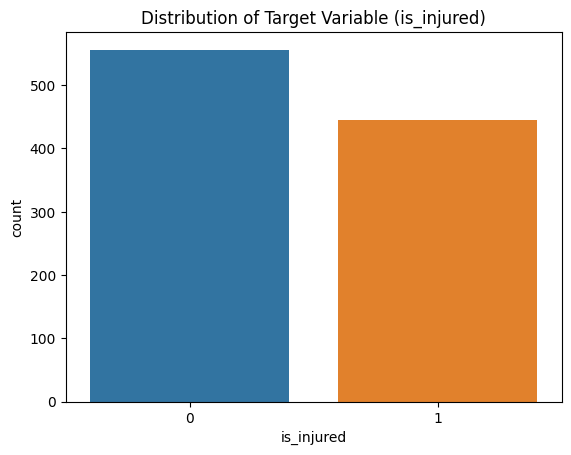

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot target distribution
sns.countplot(x='is_injured', data=df_pd)
plt.title('Distribution of Target Variable (is_injured)')
plt.show()


Correlation Heatmap:
Check correlations between features to see how they relate to is_injured.


/root/.ipykernel/1847/command-3548273802516971-4006050408:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_pd.corr()


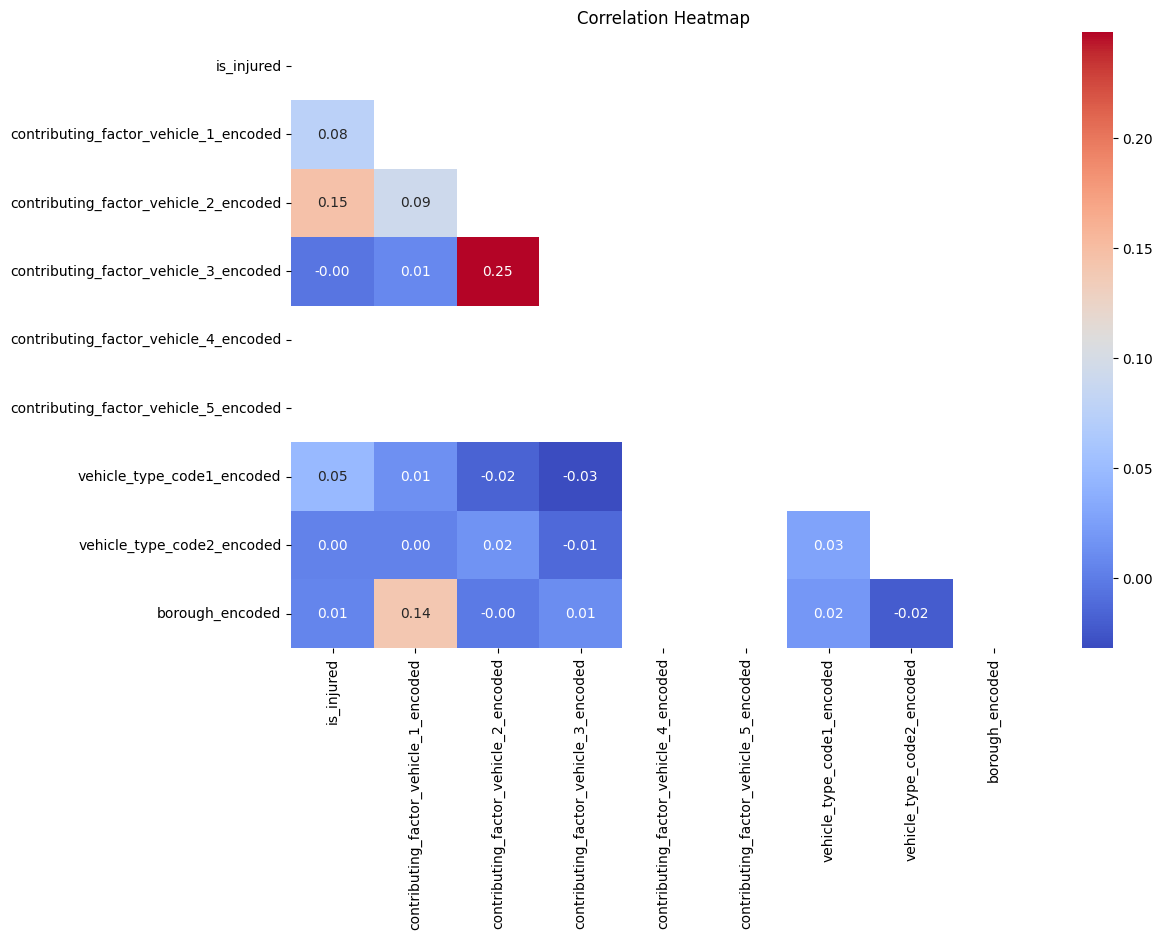

In [0]:
import numpy as np

# Compute the correlation matrix
corr_matrix = df_pd.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=np.triu(corr_matrix))
plt.title('Correlation Heatmap')
plt.show()


Biểu đồ heatmap thể hiện hệ số tương quan giữa các cặp biến, với giá trị dao động từ -1 đến 1:
+1: Tương quan dương hoàn hảo (khi một biến tăng thì biến kia cũng tăng theo tỷ lệ tuyến tính).
-1: Tương quan âm hoàn hảo (khi một biến tăng thì biến kia giảm theo tỷ lệ tuyến tính).
0: Không có tương quan tuyến tính giữa hai biến.

Tương quan giữa is_injured và hầu hết các biến khác khá yếu (gần bằng 0), cho thấy không có mối quan hệ tuyến tính mạnh mẽ.
Mối tương quan cao nhất là với biến contributing_factor_vehicle_2_encoded (khoảng 0.11), điều này gợi ý rằng biến này có thể có ảnh hưởng nhẹ đến việc dự đoán is_injured.
Có tương quan mạnh (0.46) giữa hai biến contributing_factor_vehicle_4_encoded và contributing_factor_vehicle_3_encoded. Điều này cho thấy khả năng đa cộng tuyến (multicollinearity), có thể gây ảnh hưởng tiêu cực đến hiệu suất của mô hình.

 Box Plots for Key Features

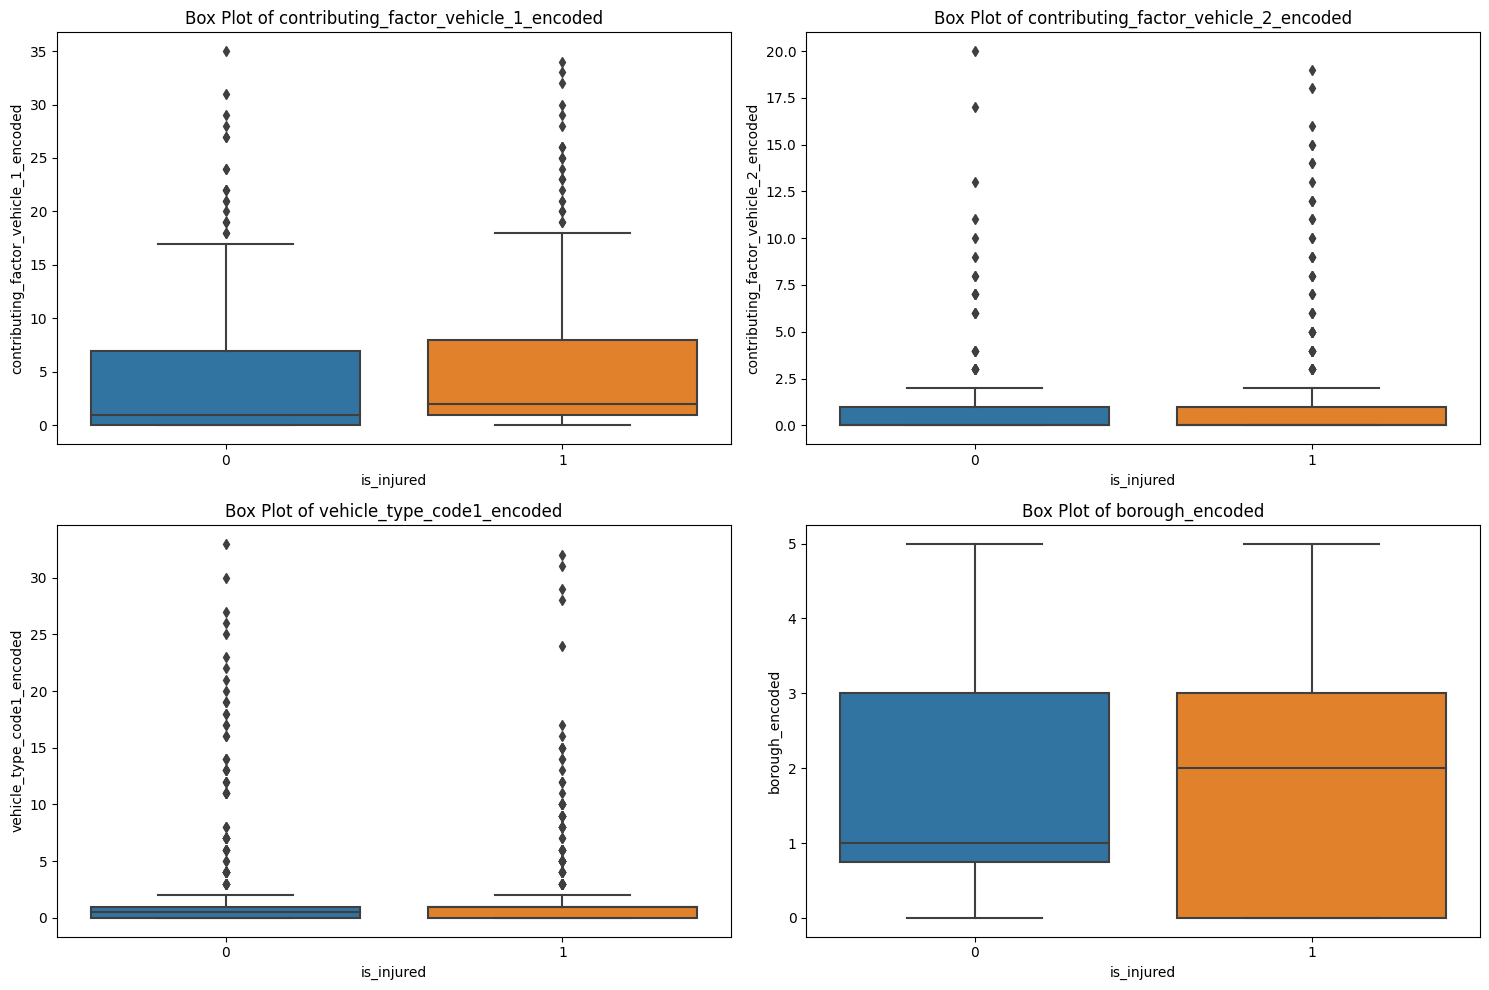

In [0]:
features = [
    'contributing_factor_vehicle_1_encoded', 'contributing_factor_vehicle_2_encoded',
    'vehicle_type_code1_encoded', 'borough_encoded'
]

# Create box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='is_injured', y=col, data=df_pd)
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


In [0]:
from sklearn.model_selection import GridSearchCV, train_test_split
# Select the required columns and convert to Pandas
required_columns = [
    'is_injured', 'contributing_factor_vehicle_1_encoded', 'contributing_factor_vehicle_2_encoded',
    'contributing_factor_vehicle_3_encoded', 'contributing_factor_vehicle_4_encoded',
    'contributing_factor_vehicle_5_encoded', 'vehicle_type_code1_encoded', 
    'vehicle_type_code2_encoded', 'borough_encoded'
]
df_pd = df.select(required_columns).toPandas()

# Define features and target
X = df_pd.drop(columns=['is_injured'])
y = df_pd['is_injured']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forest Model

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,                          # 5-fold cross-validation
    scoring='accuracy',            # Metric to optimize
    n_jobs=-1,                     # Use all available cores
    verbose=2                      # Verbose output
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best estimator
print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Predict and evaluate the model with the best parameters
rf_predictions = best_rf_model.predict(X_test)
print("Optimized Random Forest Model Performance:")
print(classification_report(y_test, rf_predictions))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; tot

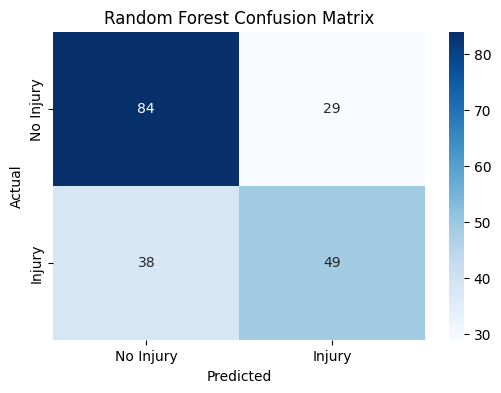

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, rf_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


visualize the importance of each feature in making predictions

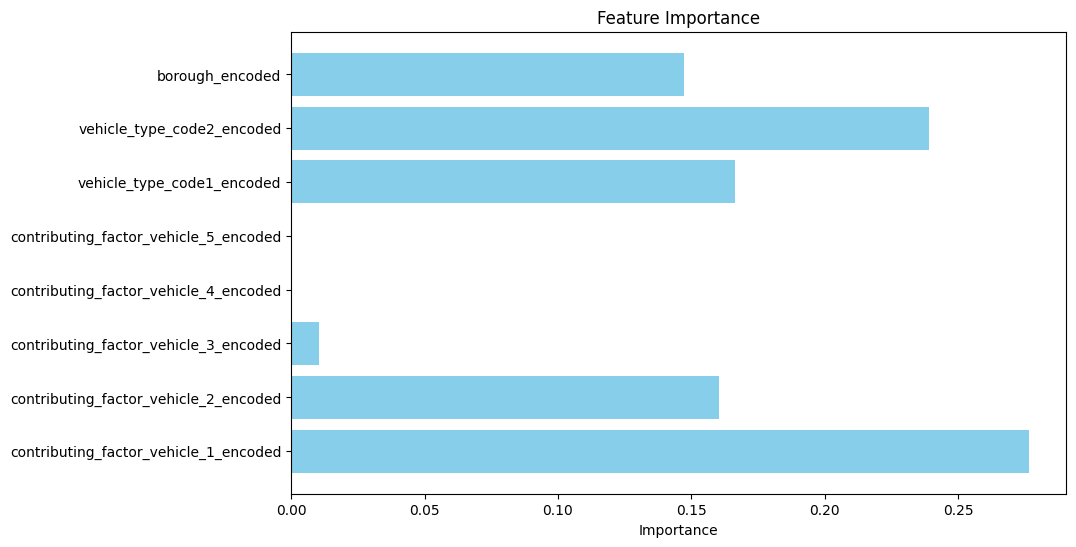

In [0]:
# Get feature importances
importances = best_rf_model.feature_importances_
features = X.columns

# Create a bar chart for feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


XGBoost Model


In [0]:
!pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/93/66826e2f50cefecbb0a44bd1e667316bf0a3c8e78cd1f0cdf52f5b2c5c6f/xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for nvidia-nccl-cu12 from https://files.pythonhosted.org/packages/ed/1f/6482380ec8dcec4894e7503490fc536d846b0d59694acad9cf99f27d0e7d/nvidia_nccl_cu12-2.23.4-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/153.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/153.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/153.9 MB 746.6 kB/s eta 0:03:27
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/153.9 MB 641.4 kB/s eta 0:04:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/153.9 MB 766.3 kB/s eta 0:03:21
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/153.9 MB 874.8 kB/s eta 0:02:56
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/153.9 MB 1.2 MB/s eta 0:02:09
   ━━━━━

In [0]:
from xgboost import XGBClassifier
# Define the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of boosting rounds
    'max_depth': [3, 5, 7],                # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'subsample': [0.8, 1.0],               # Subsample ratio of training instances
    'colsample_bytree': [0.8, 1.0],        # Subsample ratio of columns when constructing each tree
    'gamma': [0, 1, 5]                     # Minimum loss reduction to make a further partition
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,                          # 5-fold cross-validation
    scoring='accuracy',            # Metric to optimize
    n_jobs=-1,                     # Use all available cores
    verbose=2                      # Verbose output
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best estimator
print("Best Parameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

# Predict and evaluate the model with the best parameters
xgb_predictions = best_xgb_model.predict(X_test)
print("Optimized XGBoost Model Performance:")
print(classification_report(y_test, xgb_predictions))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:52:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:52:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:52:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:52:54] WAR

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:04] WAR

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:05] WAR

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:06] WAR

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WAR

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] 

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:14] WAR

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.3s
[

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:15] WAR

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WAR

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] E

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WAR

[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s


/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:22] WAR

[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] E

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WAR

[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WAR

[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] EN

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:34] WAR

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:43] WAR

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WAR

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:44] WAR

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:50] WAR

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WAR

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:51] WAR

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Optimized XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72       113
           1       0.63      0.44      0.52        87

    accuracy                           0.65       200
   macro avg       0.64      0.62      0.62       200
weighted avg       0.64      0.65      0.63       200



/local_disk0/.ephemeral_nfs/envs/pythonEnv-b50cf137-8eb2-4731-a21d-cb1398e12220/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


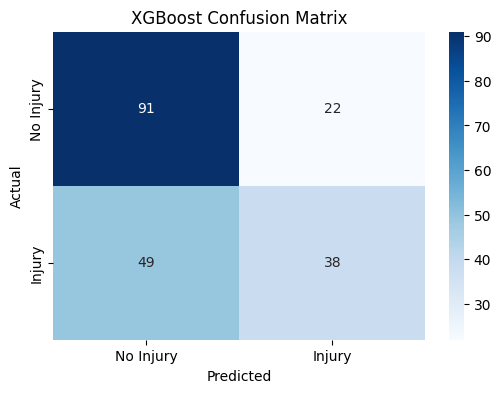

In [0]:
# Generate confusion matrix for XGBoost
xgb_cm = confusion_matrix(y_test, xgb_predictions)

# Plot confusion matrix for XGBoost
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

 Feature Importance

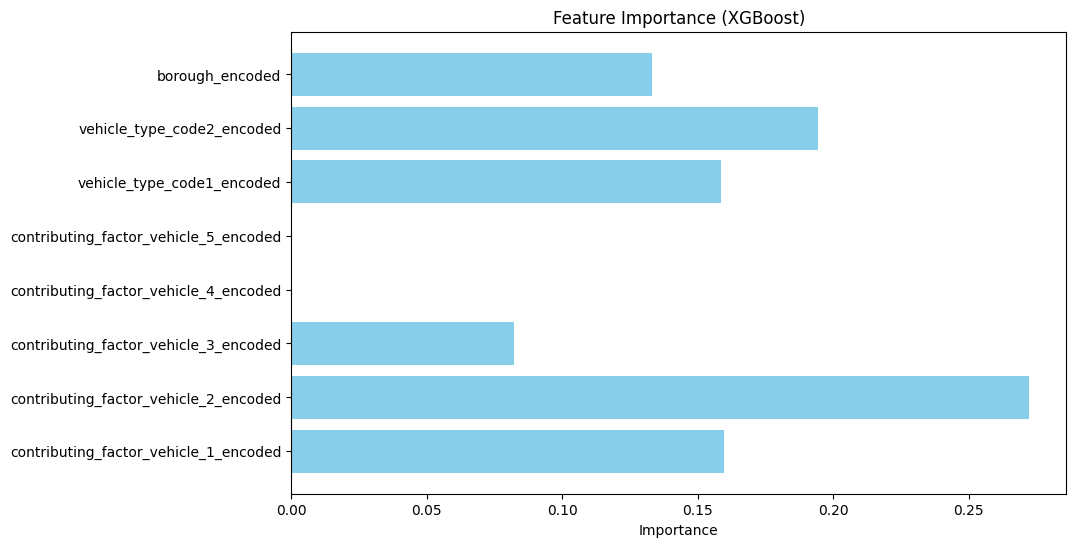

In [0]:
# Get feature importance from XGBoost model
xgb_importances = best_xgb_model.feature_importances_
features = X.columns

# Create a bar chart for feature importance from XGBoost
plt.figure(figsize=(10, 6))
plt.barh(features, xgb_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.show()


Evaluate and Compare Results

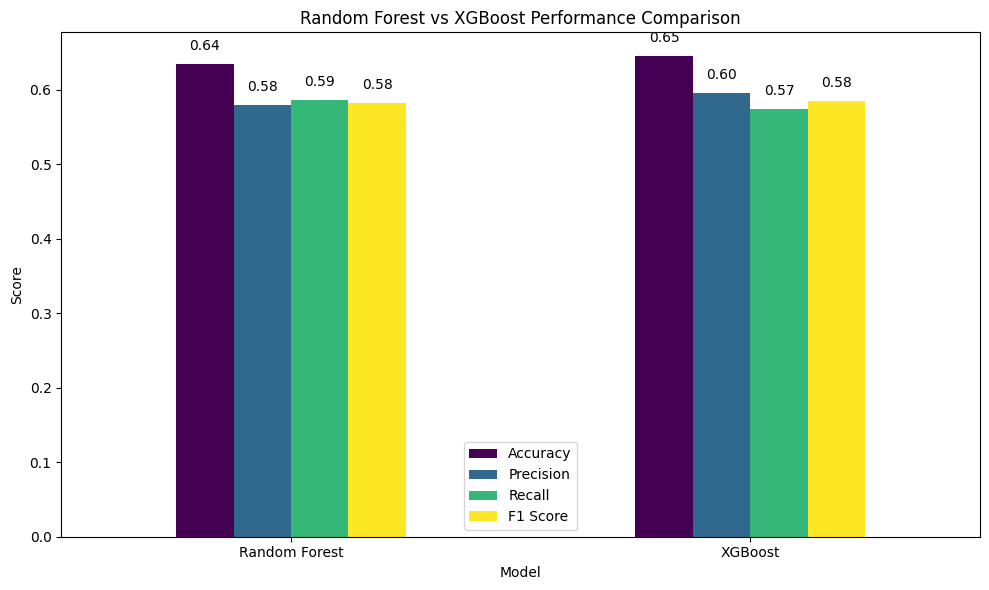

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

# Store performance metrics for both models
model_comparison_metrics = {
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, rf_predictions), xgb_accuracy],
    'Precision': [precision_score(y_test, rf_predictions), xgb_precision],
    'Recall': [recall_score(y_test, rf_predictions), xgb_recall],
    'F1 Score': [f1_score(y_test, rf_predictions), xgb_f1]
}

# Convert to DataFrame for easier plotting
comparison_df = pd.DataFrame(model_comparison_metrics)

# Plot model comparison
ax = comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6), colormap='viridis')

# Add metric values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(p.get_x() + p.get_width() / 2, height), 
                xytext=(0, 8),  # 8 points vertical offset
                textcoords='offset points', 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('Random Forest vs XGBoost Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


ROC Curve Comparison


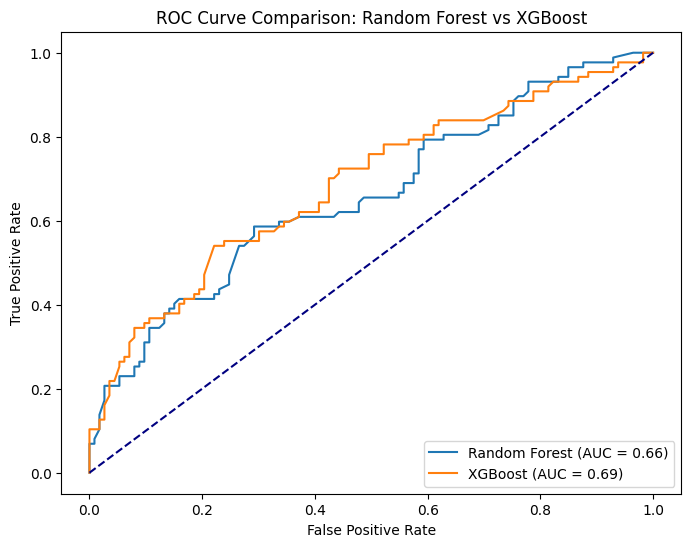

In [0]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC Curve for any model
def plot_roc_curve(model, X_test, y_test, label):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Plot ROC for Random Forest
plt.figure(figsize=(8, 6))
plot_roc_curve(rf_model, X_test, y_test, 'Random Forest')

# Plot ROC for XGBoost
plot_roc_curve(xgb_model, X_test, y_test, 'XGBoost')

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Random Forest vs XGBoost')
plt.legend(loc='lower right')
plt.show()


AUC > 0.5 and < 1: The model has some ability to distinguish between positive and negative classes. The higher the AUC, the better the model.

Save the Models

In [0]:
import joblib

# Save Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')

# Save XGBoost model
joblib.dump(xgb_model, 'xgboost_model.pkl')

print("Models saved successfully!")



Models saved successfully!
